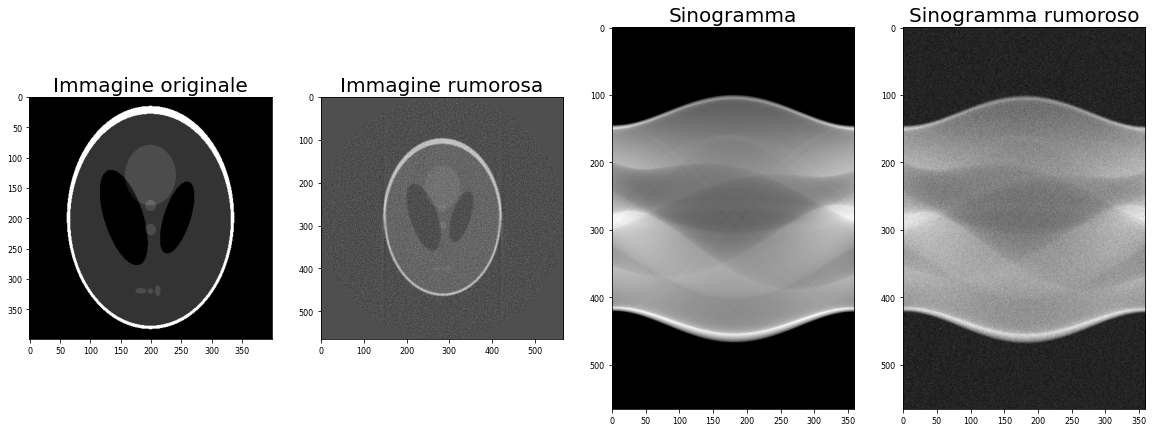

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from skimage import data
from skimage.transform import radon, iradon, resize

##### 1 #####
from PIL import Image

sourceImg = data.shepp_logan_phantom()
#sourceImg = resize(sourceImg, (sourceImg.shape[0], sourceImg.shape[1]),anti_aliasing=False)


##### 2 #####
start = 0
end = 180
step = 0.5
theta = np.arange(start, end, step)
sinogram = radon(sourceImg, theta, False)

##### 3 #####

# rumore
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  
  return kern2d/kern2d.sum()

def blurImage(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento
  (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

#generazione rumore
sigma = 0.1
corr_sinogram = blurImage(sinogram, d=3)
eta = np.random.normal(size=sinogram.shape)
eta /= np.linalg.norm(eta, 'fro')
eta *= sigma * np.linalg.norm(sinogram,'fro')

#sinogramma rumoroso
corr_sinogram = corr_sinogram + eta

##### 4 #####

#font
matplotlib.rcParams['font.size'] = 8

#show

plt.figure(0, figsize=(20, 20))

ax = plt.subplot(1, 4, 1)
ax.imshow(sourceImg, cmap='gray')
plt.title('Immagine originale', fontsize=20)

ax = plt.subplot(1, 4, 2)
ax.imshow(iradon(corr_sinogram), cmap='gray')
plt.title('Immagine rumorosa', fontsize=20)

ax = plt.subplot(1, 4, 3)
ax.imshow(sinogram, cmap='gray')
plt.title('Sinogramma', fontsize=20)

ax = plt.subplot(1, 4, 4)
ax.imshow(corr_sinogram, cmap='gray')
plt.title('Sinogramma rumoroso', fontsize=20)

plt.show()

In [ ]:
def f(x, g):
  Mx = radon(x, theta, circle=False)
  res = 0.5*np.linalg.norm(Mx - g, 2)**2
  return res

def grad_f(x,g):
  Mx = radon(x, theta, circle=False)
  out = iradon (Mx - g, theta, output_size=(sourceImg.shape[0]))
  return out

def gradientBT(x0, xTrue, g, maxIt, tol):
    #error computation
    normf = np.linalg.norm(xTrue, "fro")
    err = []
    err.append(np.linalg.norm(xTrue - x0, "fro")/normf)
    
    #init parameters
    it = 0
    x = np.copy(x0)

    grad = grad_f(x, g)
    norm = np.linalg.norm(grad, "fro")
    p = - grad
    pgrad = np.dot(grad.T, p)

    fxg = f(x, g)

    #tracking
    obj = []
    obj.append(fxg)
    alphas = []

    #backtracking parameters
    c = 0.25
    rho = 0.5

    while norm > tol and it < maxIt:

        st = time.time()

        #backtracking
        a = 1   
        while f(x + a*p, g) > fxg + a*c*np.linalg.norm(np.dot(grad.T, p), "fro") and np.abs(a) > 1e-5:
            print(a)
            a *= rho

        print()
        alphas.append(a)    

        #taking a step
        x += a*p
        
        #updating gradient and p         
        grad = grad_f(x, g)
        norm = np.linalg.norm(grad, "fro")
        p = - grad

        fxg = f(x, g)

        #memorizing error
        err.append(np.linalg.norm(xTrue - x, "fro")/normf)
        obj.append(fxg)
        it += 1
        st = time.time()-st
        print(it, st)
        
    err = np.array(err)
    obj = np.array(obj)
    alphas = np.array(alphas)
    return x, it, err, obj, alphas

In [ ]:
x0 = np.zeros(sourceImg.shape)
tol = 10**-5
xTrue = sourceImg
maxIt = 10

img1, it1, err1, obj1, alphas1 = gradientBT(x0, xTrue, corr_sinogram, maxIt, tol)


1 13.404023885726929

2 13.357929229736328

3 13.307245016098022

4 13.295428991317749

5 13.195980787277222

6 12.97554636001587

7 13.03574538230896

8 12.92597770690918

9 13.094964981079102

10 12.887683153152466


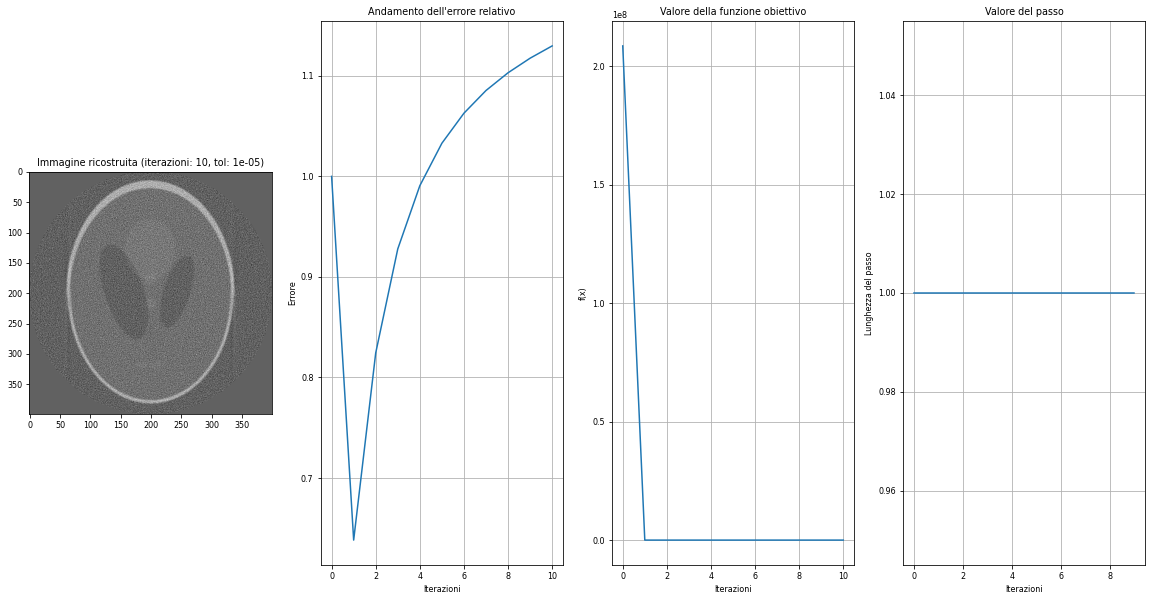

In [ ]:
plt.figure(1, figsize=(20, 10))

ax = plt.subplot(1, 4, 1)
ax.imshow(img1, cmap="gray")
plt.title("Immagine ricostruita (iterazioni: " + str(it1) + ", tol: " + str(tol) + ")")

##### 2 #####

ax = plt.subplot(1, 4, 2)
plt.title("Andamento dell'errore relativo")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("Errore")
ax.plot(err1)

##### 3 #####

ax = plt.subplot(1, 4, 3)
plt.title("Valore della funzione obiettivo")
ax.grid(True)
ax.plot(obj1)
plt.xlabel("Iterazioni")
plt.ylabel("f(x)")

ax = plt.subplot(1, 4, 4)
plt.title("Valore del passo")
ax.grid(True)
ax.plot(alphas1)
plt.xlabel("Iterazioni")
plt.ylabel("Lunghezza del passo")
plt.show()

In [ ]:
def fnorm1(x, g, l):
  Mx = radon(x, theta, circle=False)
  res = 0.5*np.linalg.norm(Mx - g, 2)**2 + l*np.linalg.norm(x,1)
  return res

def grad_fnorm1(x,g, l):
  Mx = radon(x, theta, circle=False)
  out = iradon (Mx - g, theta, output_size=(400)) + l*np.sign(x)
  return out

def gradientBT1(x0, xTrue, g, maxIt, tol, l):
    #error computation
    normf = np.linalg.norm(xTrue, "fro")
    err = []
    err.append(np.linalg.norm(xTrue - x0, "fro")/normf)
    
    #init parameters
    it = 0
    x = np.copy(x0)

    grad = grad_fnorm1(x, g, l)
    norm = np.linalg.norm(grad, "fro")
    p = - grad
    pgrad = np.dot(grad.T, p)

    fxg = fnorm1(x, g, l)

    #tracking
    obj = []
    obj.append(fxg)
    grads = []
    grads.append(norm)
    alphas = []

    #backtracking parameters
    c = 0.25
    rho = 0.5

    while norm > tol and it < maxIt:

        st = time.time()

        #backtracking
        a = 1   
        while fnorm1(x + a*p, g, l) > fxg + a*c*np.linalg.norm(np.dot(grad.T, p), "fro") and np.abs(a) > 1e-5:
            print(a)
            a *= rho

        print()
        alphas.append(a)    

        #taking a step
        x += a*p
        
        #updating gradient and p         
        grad = grad_fnorm1(x, g, l)
        norm = np.linalg.norm(grad, "fro")
        p = - grad

        fxg = fnorm1(x, g, l)

        #memorizing error
        err.append(np.linalg.norm(xTrue - x, "fro")/normf)
        obj.append(fxg)
        grads.append(norm)
        it += 1
        st = time.time()-st
        print(it, st)
        
    err = np.array(err)
    obj = np.array(obj)
    grads = np.array(grads)
    alphas = np.array(alphas)
    return x, it, err, obj, grads, alphas

In [ ]:
recImgNorm1, itNorm1, errNorm1, objNorm1, gradNorm1, alphasNorm1 = gradientBT1(x0, xTrue, corr_sinogram, 5, tol, 0.01)


1 13.384362936019897
1
0.5
0.25

2 25.877112865447998
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

3 82.87312984466553
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

4 83.24004316329956
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

5 82.71719527244568


In [ ]:
recImgNorm2, itNorm2, errNorm2, objNorm2, gradNorm2, alphasNorm2 = gradientBT1(x0, xTrue, corr_sinogram, 5, tol, 0.005)


1 13.31812047958374
1
0.5

2 21.644800662994385
1
0.5
0.25
0.125

3 29.95125961303711
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

4 82.95464658737183
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

5 82.26274156570435


In [ ]:
recImgNorm3, itNorm3, errNorm3, objNorm3, gradNorm3, alphasNorm3 = gradientBT1(x0, xTrue, corr_sinogram, 5, tol, 0.001)


1 13.33517837524414

2 13.571768522262573

3 13.46854305267334

4 13.436546087265015

5 13.62302827835083


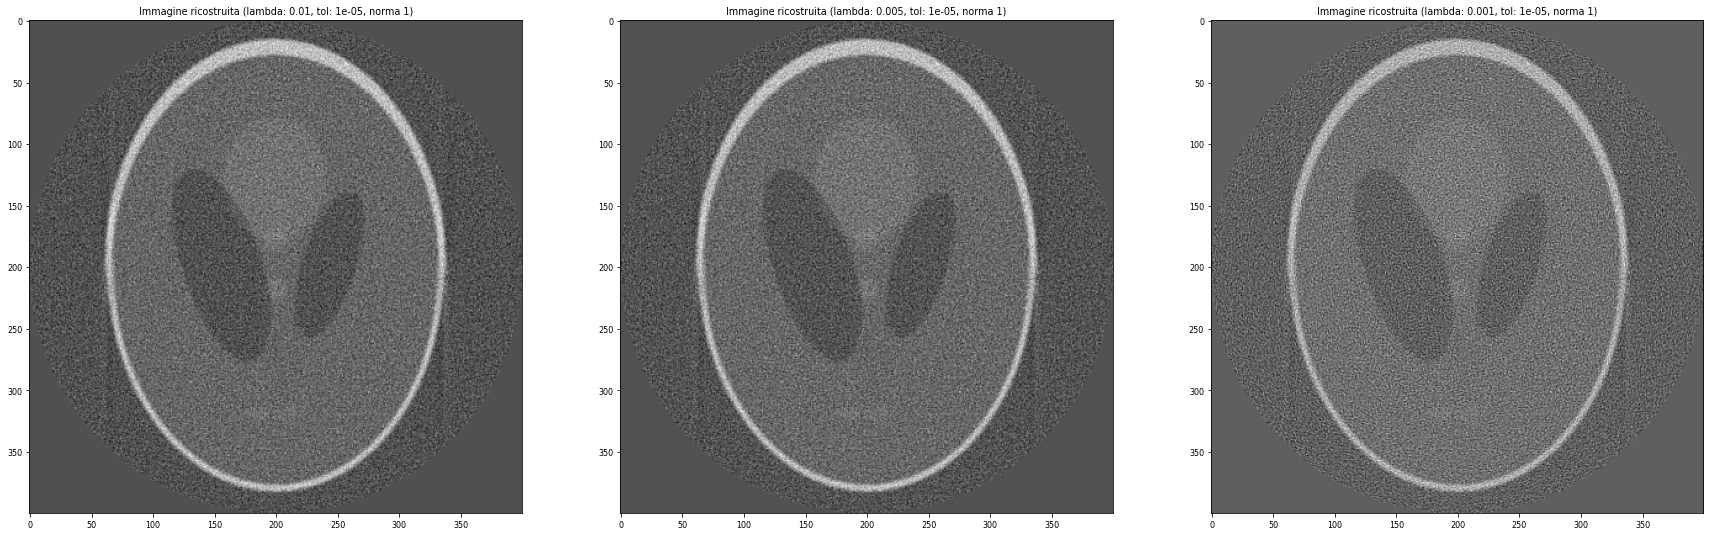

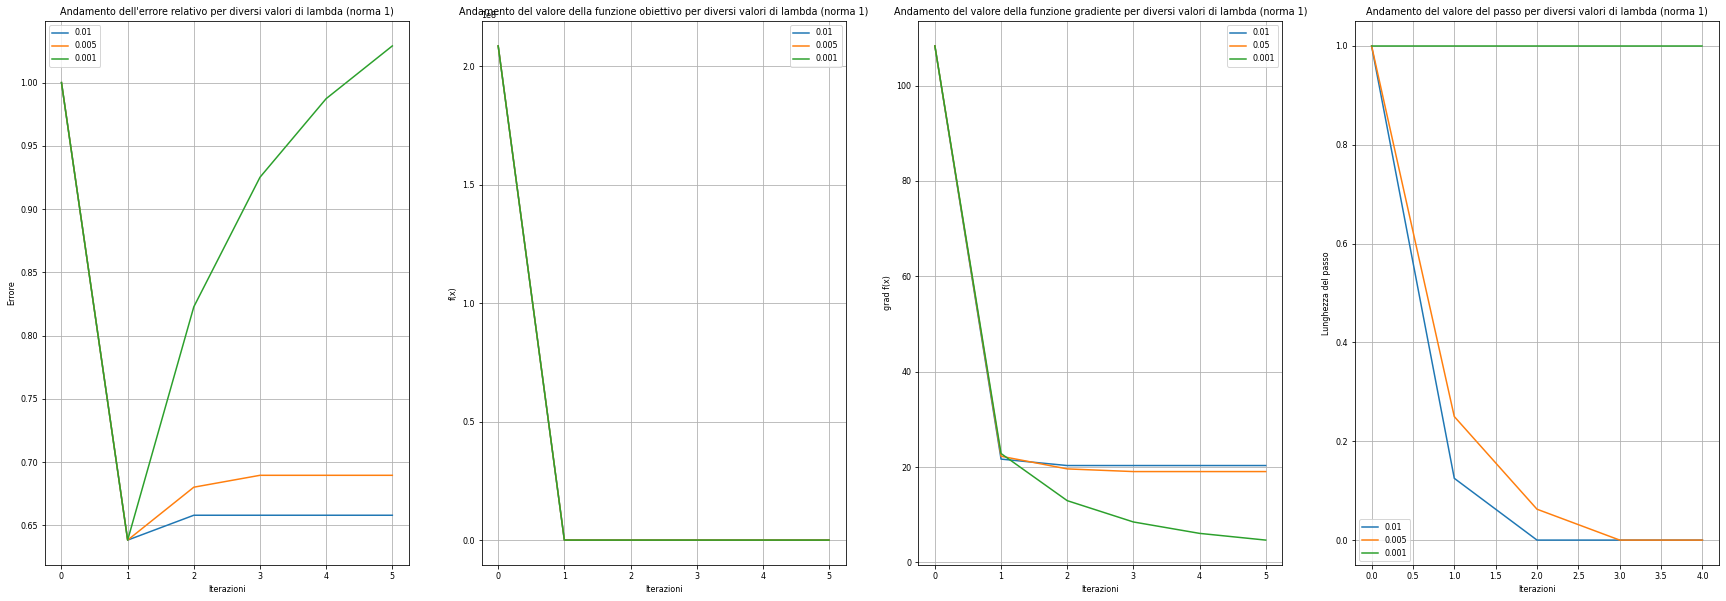

In [ ]:
a = 0

plt.figure(2, figsize=(30, 10))

ax = plt.subplot(1, 3, 1)
ax.imshow(recImgNorm1, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.01, tol: " + str(tol) + ", norma 1)")

ax = plt.subplot(1, 3, 2)
ax.imshow(recImgNorm2, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.005, tol: " + str(tol) + ", norma 1)")

ax = plt.subplot(1, 3, 3)
ax.imshow(recImgNorm3, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.001, tol: " + str(tol) + ", norma 1)")

##### 1 #####
plt.figure(3, figsize=(30, 10))

ax = plt.subplot(1, 4, 1)
plt.title("Andamento dell'errore relativo per diversi valori di lambda (norma 1)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("Errore")
ax.plot(errNorm1[a:], label="0.01")
ax.plot(errNorm2[a:], label="0.005")
ax.plot(errNorm3[a:], label="0.001")
ax.legend(loc="best")

##### 2 #####

ax = plt.subplot(1, 4, 2)
plt.title("Andamento del valore della funzione obiettivo per diversi valori di lambda (norma 1)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("f(x)")
ax.plot(objNorm1[a:], label="0.01")
ax.plot(objNorm2[a:], label="0.005")
ax.plot(objNorm3[a:], label="0.001")

ax.legend(loc="best")

##### 3 #####

ax = plt.subplot(1, 4, 3)
plt.title("Andamento del valore della funzione gradiente per diversi valori di lambda (norma 1)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("grad f(x)")
ax.plot(gradNorm1[a:], label="0.01")
ax.plot(gradNorm2[a:], label="0.05")
ax.plot(gradNorm3[a:], label="0.001")

ax.legend(loc="best")

ax = plt.subplot(1, 4, 4)
plt.title("Andamento del valore del passo per diversi valori di lambda (norma 1)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("Lunghezza del passo")
ax.plot(alphasNorm1[a:], label="0.01")
ax.plot(alphasNorm2[a:], label="0.005")
ax.plot(alphasNorm3[a:], label="0.001")
ax.legend(loc="best")

In [ ]:
def fnorm2(x, g, l):
  Mx = radon(x, theta, circle=False)
  res = 0.5*np.linalg.norm(Mx - g, 2)**2 + l*(np.linalg.norm(x,2)**2)
  return res

def grad_fnorm2(x,g, l):
  Mx = radon(x, theta, circle=False)
  out = iradon (Mx - g, theta, output_size=(400)) + 2*l*x
  return out

def gradientBT2(x0, xTrue, g, maxIt, tol, l):
    #error computation
    normf = np.linalg.norm(xTrue, "fro")
    err = []
    err.append(np.linalg.norm(xTrue - x0, "fro")/normf)
    
    #init parameters
    it = 0
    x = np.copy(x0)

    grad = grad_fnorm2(x, g, l)
    norm = np.linalg.norm(grad, "fro")
    p = - grad
    pgrad = np.dot(grad.T, p)

    fxg = fnorm2(x, g, l)

    #tracking
    obj = []
    obj.append(fxg)
    grads = []
    grads.append(norm)
    alphas = []

    #backtracking parameters
    c = 0.25
    rho = 0.5

    while norm > tol and it < maxIt:

        st = time.time()

        #backtracking
        a = 1   
        while fnorm2(x + a*p, g, l) > fxg + a*c*np.linalg.norm(np.dot(grad.T, p), "fro") and np.abs(a) > 1e-5:
            print(a)
            a *= rho

        print()
        alphas.append(a)    

        #taking a step
        x += a*p
        
        #updating gradient and p         
        grad = grad_fnorm2(x, g, l)
        norm = np.linalg.norm(grad, "fro")
        p = - grad

        fxg = fnorm2(x, g, l)

        #memorizing error
        err.append(np.linalg.norm(xTrue - x, "fro")/normf)
        obj.append(fxg)
        grads.append(norm)
        it += 1
        st = time.time()-st
        print(it, st)
        
    err = np.array(err)
    obj = np.array(obj)
    alphas = np.array(alphas)
    grads = np.array(grads)
    return x, it, err, obj, grads, alphas

In [ ]:
recImg2Norm1, it2Norm1, err2Norm1, obj2Norm1, grad2Norm1, alphas2Norm1 = gradientBT2(x0, xTrue, corr_sinogram, 5, tol, 0.01)


1 13.528717041015625
1
0.5

2 22.033053874969482
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

3 85.21720838546753
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

4 83.46585845947266
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

5 83.37056398391724


In [ ]:
recImg2Norm2, it2Norm2, err2Norm2, obj2Norm2, grad2Norm2, alphas2Norm2 = gradientBT2(x0, xTrue, corr_sinogram, 5, tol, 0.005)


1 13.27614450454712
1

2 17.488465547561646
1
0.5
0.25
0.125
0.0625

3 33.614288330078125
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

4 82.89032888412476
1
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05

5 83.13409447669983


In [ ]:
recImg2Norm3, it2Norm3, err2Norm3, obj2Norm3, grad2Norm3, alphas2Norm3 = gradientBT2(x0, xTrue, corr_sinogram, 5, tol, 0.001)


1 13.39223599433899

2 13.383850812911987

3 13.447907447814941

4 13.276518106460571

5 13.31995701789856


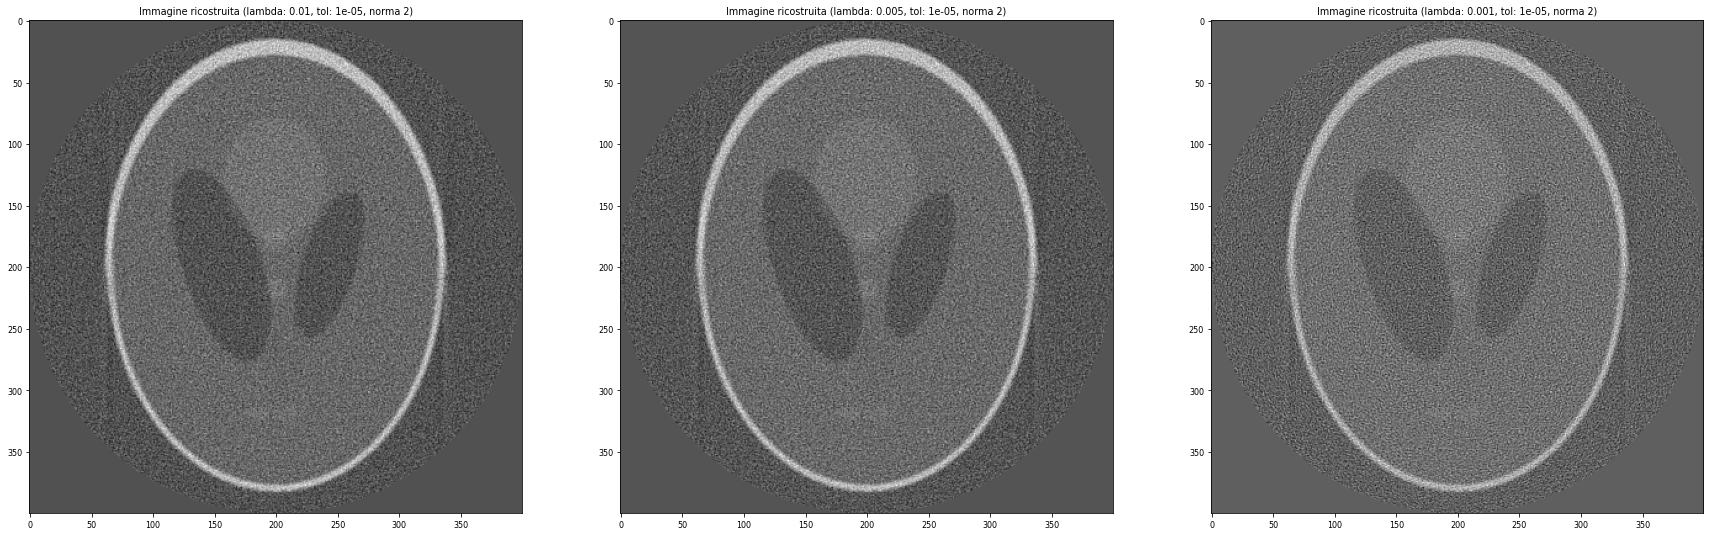

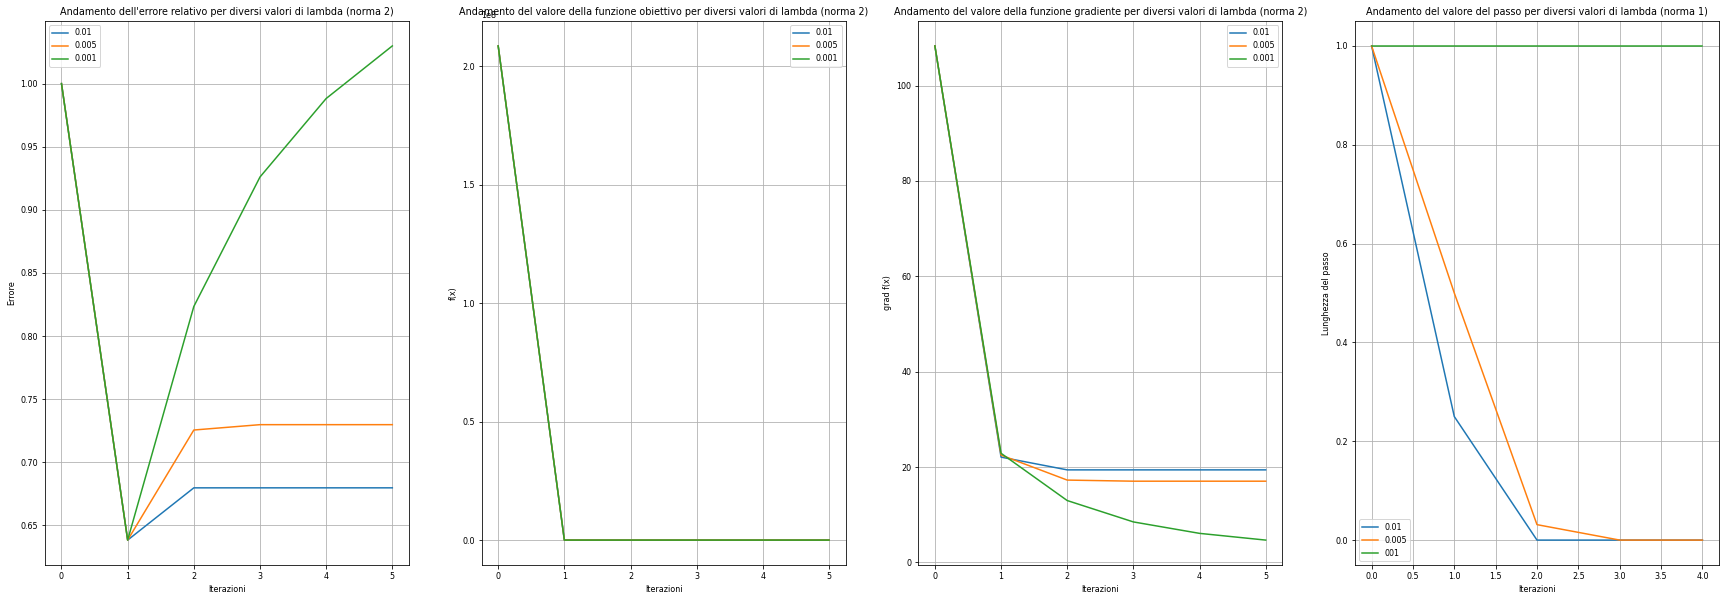

In [ ]:
plt.figure(4, figsize=(30, 10))

ax = plt.subplot(1, 3, 1)
ax.imshow(recImg2Norm1, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.01, tol: " + str(tol) + ", norma 2)")

ax = plt.subplot(1, 3, 2)
ax.imshow(recImg2Norm2, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.005, tol: " + str(tol) + ", norma 2)")

ax = plt.subplot(1, 3, 3)
ax.imshow(recImg2Norm3, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.001, tol: " + str(tol) + ", norma 2)")

##### 2 #####

plt.figure(5, figsize=(30, 10))

ax = plt.subplot(1, 4, 1)
plt.title("Andamento dell'errore relativo per diversi valori di lambda (norma 2)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("Errore")
ax.plot(err2Norm1[a:], label="0.01")
ax.plot(err2Norm2[a:], label="0.005")
ax.plot(err2Norm3[a:], label="0.001")

ax.legend(loc="best")

ax = plt.subplot(1, 4, 2)
plt.title("Andamento del valore della funzione obiettivo per diversi valori di lambda (norma 2)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("f(x)")
ax.plot(obj2Norm1[a:], label="0.01")
ax.plot(obj2Norm2[a:], label="0.005")
ax.plot(obj2Norm3[a:], label="0.001")

ax.legend(loc="best")

ax = plt.subplot(1, 4, 3)
plt.title("Andamento del valore della funzione gradiente per diversi valori di lambda (norma 2)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("grad f(x)")
ax.plot(grad2Norm1[a:], label="0.01")
ax.plot(grad2Norm2[a:], label="0.005")
ax.plot(grad2Norm3[a:], label="0.001")

ax.legend(loc="best")

ax = plt.subplot(1, 4, 4)
plt.title("Andamento del valore del passo per diversi valori di lambda (norma 1)")
ax.grid(True)
plt.xlabel("Iterazioni")
plt.ylabel("Lunghezza del passo")
ax.plot(alphas2Norm1[a:], label="0.01")
ax.plot(alphas2Norm2[a:], label="0.005")
ax.plot(alphas2Norm3[a:], label="001")

ax.legend(loc="best")

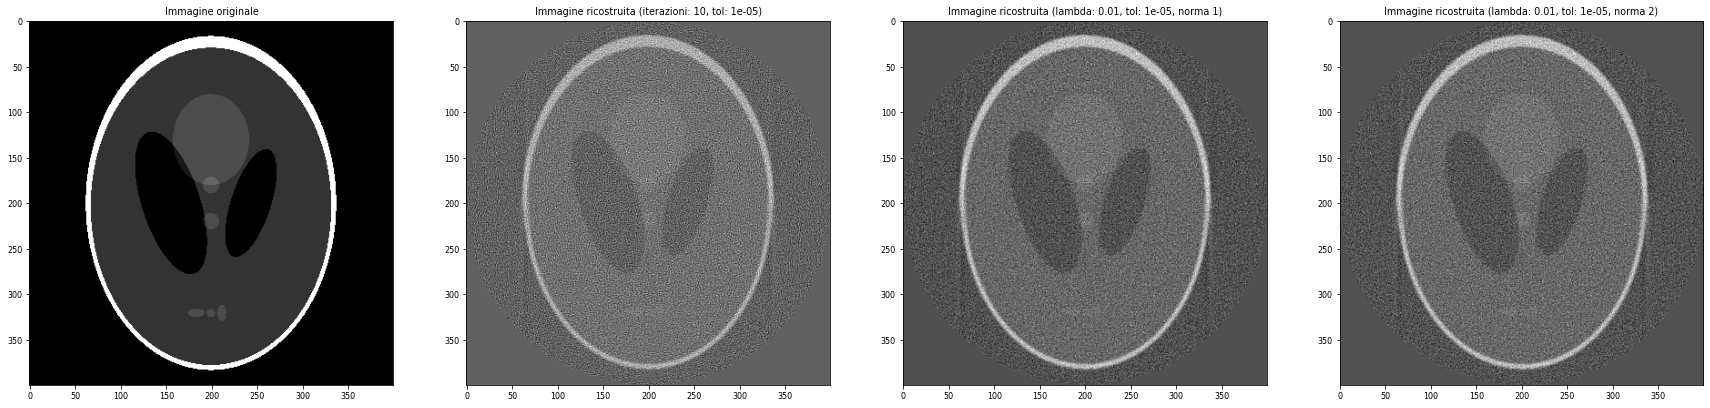

In [ ]:
a=0
plt.figure(figsize=(30, 10))

ax = plt.subplot(1, 4, 1)
ax.imshow(sourceImg, cmap='gray')
plt.title('Immagine originale')

ax = plt.subplot(1, 4, 2)
ax.imshow(img1, cmap="gray")
plt.title("Immagine ricostruita (iterazioni: " + str(it1) + ", tol: " + str(tol) + ")")

ax = plt.subplot(1, 4, 3)
ax.imshow(recImgNorm1, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.01, tol: " + str(tol) + ", norma 1)")

ax = plt.subplot(1, 4, 4)
ax.imshow(recImg2Norm1, cmap="gray")
plt.title("Immagine ricostruita (lambda: 0.01, tol: " + str(tol) + ", norma 2)")
plt.show()

No handles with labels found to put in legend.


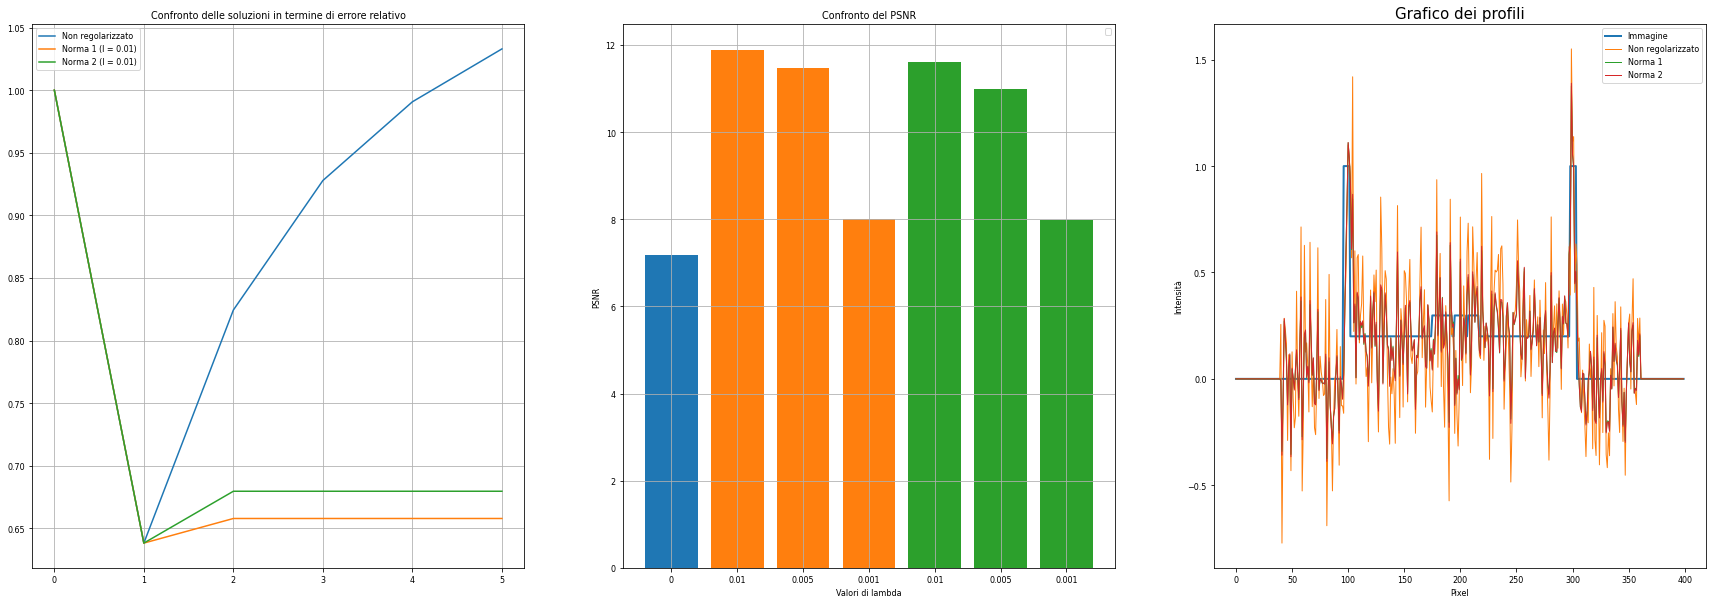

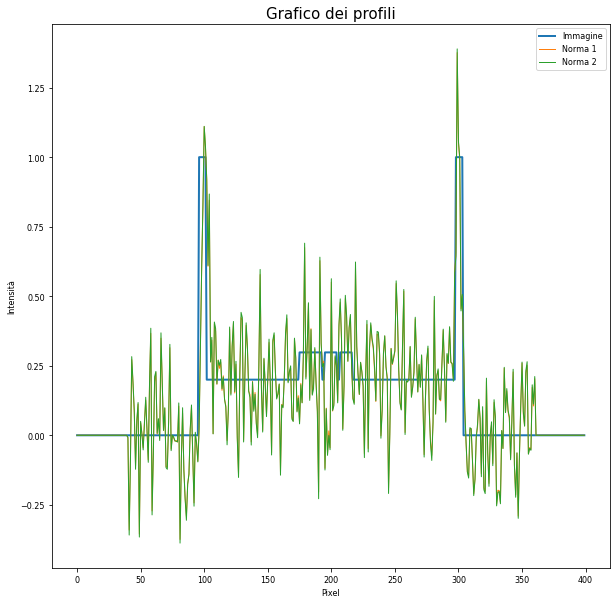

In [ ]:
import math

def PSNR(XTrue, x):
  m,n = np.shape(XTrue)
  sum = 0
  for i in range(0,m-1):
    for j in range(0,n-1):
      sum += np.linalg.norm(XTrue[i,j]-x[i,j])**2
  MSE = (1/m*n)*sum
  PSNR = 20*np.log10(255/math.sqrt(MSE))
  return PSNR

plt.figure(figsize=(30, 10))

ax=plt.subplot(1,3,1)
plt.title("Confronto delle soluzioni in termine di errore relativo")
plt.plot(err1[a:6], label="Non regolarizzato")
plt.plot(errNorm1[a:], label="Norma 1 (l = 0.01)")
plt.plot(err2Norm1[a:], label="Norma 2 (l = 0.01)")
plt.grid(True)
plt.legend(loc="best")


ax = plt.subplot(1, 3, 2)
plt.title("Confronto del PSNR")
plt.grid(True)
ax.bar(0, height=PSNR(xTrue, img1))
ax.bar(np.arange(1, 4), height=[PSNR(xTrue, recImgNorm1), PSNR(xTrue, recImgNorm2), PSNR(xTrue, recImgNorm3)])
ax.bar(np.arange(4, 7), height=[PSNR(xTrue, recImg2Norm1), PSNR(xTrue, recImg2Norm2), PSNR(xTrue, recImg2Norm3)])
plt.xticks(np.arange(0, 7), ["0", "0.01", "0.005", "0.001", "0.01", "0.005", "0.001"])
plt.xlabel("Valori di lambda")
plt.ylabel("PSNR")
plt.legend(loc="best")

row = 320

ax = plt.subplot(1, 3, 3)
srcProf = sourceImg[row, :] # riga m di f_true
noregProf = img1[row, :]
norm1Prof = recImgNorm1[row, :] # riga m di ricostruzione f
norm2Prof = recImg2Norm1[row, :]
plt.title("Grafico dei profili", fontsize=15)
ax.plot(srcProf, label='Immagine', linewidth=2)
ax.plot(noregProf, label="Non regolarizzato", linewidth=1)
ax.plot(norm1Prof, label="Norma 1", linewidth=1)
ax.plot(norm2Prof, label="Norma 2", linewidth=1)
plt.legend(loc="best")
plt.xticks();
plt.yticks()
plt.xlabel('Pixel');
plt.ylabel('Intensità')
plt.show()

plt.figure(figsize=(10, 10))
srcProf = sourceImg[row, :] # riga m di f_true
noregProf = img1[row, :]
norm1Prof = recImgNorm1[row, :] # riga m di ricostruzione f
norm2Prof = recImg2Norm1[row, :]
plt.title("Grafico dei profili", fontsize=15)
plt.plot(srcProf, label='Immagine', linewidth=2)
#plt.plot(noregProf, label="Non regolarizzato", linewidth=1)
plt.plot(norm1Prof, label="Norma 1", linewidth=1)
plt.plot(norm2Prof, label="Norma 2", linewidth=1)
plt.legend(loc="best")
plt.xticks();
plt.yticks()
plt.xlabel('Pixel');
plt.ylabel('Intensità')
plt.show()